In [1]:
# load and plot daily births dataset
from pandas import read_csv
from matplotlib import pyplot
%matplotlib inline

# How to Develop Simple Methods for Univariate Forecasting

In [22]:
# example of a one-step naive forecast
def naive_forecast(history, n):
    return history[-n]
# define dataset
data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
print(data)
# test naive forecast
for i in range(1, len(data)+1):
    print(naive_forecast(data, i))

[10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
100.0
90.0
80.0
70.0
60.0
50.0
40.0
30.0
20.0
10.0


# Case Study 1: No Trend or Seasonality

In [4]:
# grid search simple forecasts
from math import sqrt
from numpy import mean
from numpy import median
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error

#one-step simple forecast
def simple_forecast(history, config):
            n, offset, avg_type = config
             # persist value, ignore other config
            if avg_type == 'persist':
                return history[-n]
             # collect values to average
            values = list()
            if offset == 1:
                values = history[-n:]
            else:
            # skip bad configs
               if n*offset > len(history):
                    raise Exception('Config beyond end of data: %d %d' % (n,offset))
            # try and collect n values using offset
               for i in range(1, n+1):
                    ix = i * offset
                    values.append(history[-ix])
            # check if we can average
            if len(values) < 2:
                 raise Exception('Cannot calculate average')
            # mean of last n values
            if avg_type == 'mean':
                return mean(values)
                # median of last n values
                return median(values)

# root mean squared error or rmse
def measure_rmse(actual, predicted):
     return sqrt(mean_squared_error(actual, predicted))
    
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
      predictions = list()
# split dataset
      train, test = train_test_split(data, n_test)
# seed history with training dataset
      history = [x for x in train]
# step over each time step in the test set
      for i in range(len(test)):
# fit model and make forecast for history
          yhat = simple_forecast(history, cfg)
# store forecast in list of predictions
          predictions.append(yhat)
# add actual observation to history for the next loop
          history.append(test[i])
# estimate prediction error
      error = measure_rmse(test, predictions)
      return error
    
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
        result = None
# convert config to a key
        key = str(cfg)
# show all warnings and fail on exception if debugging
        if debug:
         result = walk_forward_validation(data, n_test, cfg)
        else:
# one failure during model validation suggests an unstable config
            try:
# never show warnings when grid searching, too noisy
               with catch_warnings():
                    filterwarnings("ignore")
                    result = walk_forward_validation(data, n_test, cfg)
            except:
                 error = None
# check for an interesting result
        if result is not None:
             print(' > Model[%s] %.3f' % (key, result))
        return (key, result)


# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
        scores = None
        if parallel:
# execute configs in parallel
         executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
         tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
         scores = executor(tasks)
        else:
            scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
# remove empty results
        scores = [r for r in scores if r[1] != None]
# sort configs by error, asc
        scores.sort(key=lambda tup: tup[1])
        return scores
    
# create a set of simple configs to try
def simple_configs(max_length, offsets=[1]):
        configs = list()
        for i in range(1, max_length+1):
            for o in offsets:
                for t in ['persist', 'mean', 'median']:
                        cfg = [i, o, t]
                        configs.append(cfg)
        return configs

In [2]:
#if __name__ == '__main__':
# define dataset
data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
# data split
n_test = 4
# model configs
max_length = len(data) - n_test
cfg_list = simple_configs(max_length)
# grid search
scores = grid_search(data, cfg_list, n_test,parallel=False)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

 > Model[[1, 1, 'persist']] 10.000
 > Model[[2, 1, 'persist']] 20.000
 > Model[[2, 1, 'mean']] 15.000
 > Model[[3, 1, 'persist']] 30.000
 > Model[[3, 1, 'mean']] 20.000
 > Model[[4, 1, 'persist']] 40.000
 > Model[[4, 1, 'mean']] 25.000
 > Model[[5, 1, 'persist']] 50.000
 > Model[[5, 1, 'mean']] 30.000
 > Model[[6, 1, 'persist']] 60.000
 > Model[[6, 1, 'mean']] 35.000
done
[1, 1, 'persist'] 10.0
[2, 1, 'mean'] 15.0
[2, 1, 'persist'] 20.0


In [2]:
import os
os.getcwd()

'C:\\Users\\MeghanaAishwarya\\Downloads'

(365, 1)


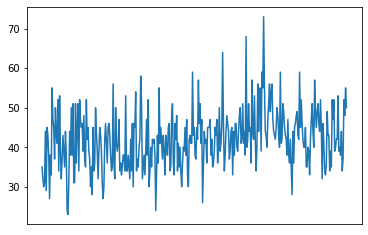

In [6]:
# load and plot daily births dataset
from pandas import read_csv
from matplotlib import pyplot
%matplotlib inline
# load
series = read_csv('daily-total-female-births.csv', header=0, index_col=0)
# summarize shape
print(series.shape)
# plot
pyplot.plot(series)
pyplot.xticks([])
pyplot.show()

In [7]:
# define dataset
series = read_csv('daily-total-female-births.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 165
# model configs
max_length = len(data) - n_test
cfg_list = simple_configs(max_length)

In [8]:
max_length

200

In [10]:
#cfg_list

In [8]:
# grid search

scores = grid_search(data, cfg_list, n_test,parallel=False)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

 > Model[[1, 1, 'persist']] 8.722
 > Model[[2, 1, 'persist']] 9.284
 > Model[[2, 1, 'mean']] 7.884
 > Model[[3, 1, 'persist']] 9.320
 > Model[[3, 1, 'mean']] 7.518
 > Model[[4, 1, 'persist']] 9.249
 > Model[[4, 1, 'mean']] 7.290
 > Model[[5, 1, 'persist']] 9.415
 > Model[[5, 1, 'mean']] 7.204
 > Model[[6, 1, 'persist']] 9.737
 > Model[[6, 1, 'mean']] 7.222
 > Model[[7, 1, 'persist']] 8.791
 > Model[[7, 1, 'mean']] 7.042
 > Model[[8, 1, 'persist']] 10.172
 > Model[[8, 1, 'mean']] 7.140
 > Model[[9, 1, 'persist']] 10.175
 > Model[[9, 1, 'mean']] 7.200
 > Model[[10, 1, 'persist']] 9.956
 > Model[[10, 1, 'mean']] 7.209
 > Model[[11, 1, 'persist']] 9.873
 > Model[[11, 1, 'mean']] 7.201
 > Model[[12, 1, 'persist']] 10.334
 > Model[[12, 1, 'mean']] 7.246
 > Model[[13, 1, 'persist']] 10.020
 > Model[[13, 1, 'mean']] 7.238
 > Model[[14, 1, 'persist']] 9.392
 > Model[[14, 1, 'mean']] 7.170
 > Model[[15, 1, 'persist']] 9.634
 > Model[[15, 1, 'mean']] 7.136
 > Model[[16, 1, 'persist']] 9.891
 > Mo

In [2]:
%matplotlib inline

# Case Study 2: Trend

(36, 1)


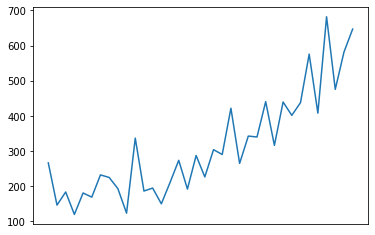

In [9]:
# load and plot monthly shampoo sales dataset
from pandas import read_csv
from matplotlib import pyplot
# load
series = read_csv('monthly-shampoo-sales.csv', header=0, index_col=0)
# summarize shape
print(series.shape)
# plot
pyplot.plot(series)
pyplot.xticks([])
pyplot.show()

In [13]:
#cfg_list

In [11]:
series = read_csv('monthly-shampoo-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# model configs
max_length = len(data) - n_test
cfg_list = simple_configs(max_length)
# grid search
scores = grid_search(data, cfg_list, n_test,parallel=False)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

 > Model[[1, 1, 'persist']] 136.761
 > Model[[2, 1, 'persist']] 95.695
 > Model[[2, 1, 'mean']] 96.011
 > Model[[3, 1, 'persist']] 123.969
 > Model[[3, 1, 'mean']] 96.403
 > Model[[4, 1, 'persist']] 136.813
 > Model[[4, 1, 'mean']] 100.609
 > Model[[5, 1, 'persist']] 127.656
 > Model[[5, 1, 'mean']] 101.862
 > Model[[6, 1, 'persist']] 165.500
 > Model[[6, 1, 'mean']] 110.425
 > Model[[7, 1, 'persist']] 164.514
 > Model[[7, 1, 'mean']] 115.500
 > Model[[8, 1, 'persist']] 186.545
 > Model[[8, 1, 'mean']] 122.807
 > Model[[9, 1, 'persist']] 193.951
 > Model[[9, 1, 'mean']] 128.902
 > Model[[10, 1, 'persist']] 205.511
 > Model[[10, 1, 'mean']] 135.664
 > Model[[11, 1, 'persist']] 216.364
 > Model[[11, 1, 'mean']] 141.511
 > Model[[12, 1, 'persist']] 240.473
 > Model[[12, 1, 'mean']] 149.228
 > Model[[13, 1, 'persist']] 242.701
 > Model[[13, 1, 'mean']] 155.422
 > Model[[14, 1, 'persist']] 252.026
 > Model[[14, 1, 'mean']] 161.750
 > Model[[15, 1, 'persist']] 259.904
 > Model[[15, 1, 'mean'

#  Case Study 3: Seasonality

(240, 1)


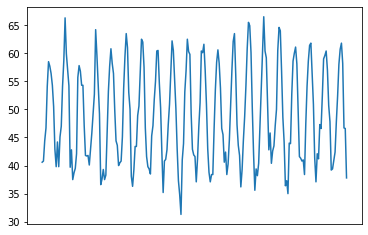

In [14]:
# load and plot monthly mean temp dataset
from pandas import read_csv
from matplotlib import pyplot
# load
series = read_csv('monthly-mean-temp.csv', header=0, index_col=0)
# summarize shape
print(series.shape)
# plot
pyplot.plot(series)
pyplot.xticks([])
pyplot.show()

In [15]:
# if __name__ == '__main__':
# define dataset
series = read_csv('monthly-mean-temp.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# model configs
max_length = len(data) - n_test
cfg_list = simple_configs(max_length, offsets=[1,12])
# grid search
scores = grid_search(data, cfg_list, n_test,parallel=False)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

 > Model[[1, 1, 'persist']] 5.143
 > Model[[1, 12, 'persist']] 5.143
 > Model[[2, 1, 'persist']] 8.492
 > Model[[2, 1, 'mean']] 6.538
 > Model[[2, 12, 'persist']] 8.492
 > Model[[2, 12, 'mean']] 1.589
 > Model[[3, 1, 'persist']] 12.006
 > Model[[3, 1, 'mean']] 8.155
 > Model[[3, 12, 'persist']] 12.006
 > Model[[3, 12, 'mean']] 1.714
 > Model[[4, 1, 'persist']] 14.252
 > Model[[4, 1, 'mean']] 9.442
 > Model[[4, 12, 'persist']] 14.252
 > Model[[4, 12, 'mean']] 1.502
 > Model[[5, 1, 'persist']] 15.418
 > Model[[5, 1, 'mean']] 10.311
 > Model[[5, 12, 'persist']] 15.418
 > Model[[5, 12, 'mean']] 1.719
 > Model[[6, 1, 'persist']] 15.725
 > Model[[6, 1, 'mean']] 10.813
 > Model[[6, 12, 'persist']] 15.725
 > Model[[6, 12, 'mean']] 1.731
 > Model[[7, 1, 'persist']] 15.127
 > Model[[7, 1, 'mean']] 10.959
 > Model[[7, 12, 'persist']] 15.127
 > Model[[7, 12, 'mean']] 1.682
 > Model[[8, 1, 'persist']] 13.563
 > Model[[8, 1, 'mean']] 10.783
 > Model[[8, 12, 'persist']] 13.563
 > Model[[8, 12, 'mean'

# Case Study 4: Trend and Seasonality

(108, 1)


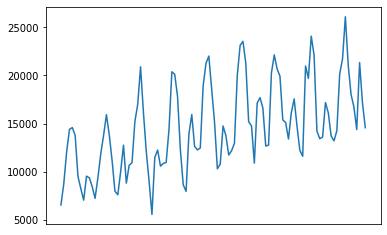

In [16]:
# load and plot monthly car sales dataset
from pandas import read_csv
from matplotlib import pyplot
# load
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
# summarize shape
print(series.shape)
# plot
pyplot.plot(series)
pyplot.xticks([])
pyplot.show()

In [17]:
# define dataset
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# model configs
max_length = len(data) - n_test
cfg_list = simple_configs(max_length, offsets=[1,12])
# grid search

scores = grid_search(data, cfg_list, n_test,parallel=False)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
     print(cfg, error)

 > Model[[1, 1, 'persist']] 3783.966
 > Model[[1, 12, 'persist']] 3783.966
 > Model[[2, 1, 'persist']] 5171.658
 > Model[[2, 1, 'mean']] 4119.852
 > Model[[2, 12, 'persist']] 5171.658
 > Model[[2, 12, 'mean']] 2215.186
 > Model[[3, 1, 'persist']] 6000.907
 > Model[[3, 1, 'mean']] 4474.174
 > Model[[3, 12, 'persist']] 6000.907
 > Model[[3, 12, 'mean']] 2115.198
 > Model[[4, 1, 'persist']] 6285.170
 > Model[[4, 1, 'mean']] 4646.905
 > Model[[4, 12, 'persist']] 6285.170
 > Model[[4, 12, 'mean']] 2385.125
 > Model[[5, 1, 'persist']] 5668.407
 > Model[[5, 1, 'mean']] 4535.757
 > Model[[5, 12, 'persist']] 5668.407
 > Model[[5, 12, 'mean']] 2843.253
 > Model[[6, 1, 'persist']] 5798.153
 > Model[[6, 1, 'mean']] 4491.612
 > Model[[6, 12, 'persist']] 5798.153
 > Model[[6, 12, 'mean']] 3306.010
 > Model[[7, 1, 'persist']] 6325.608
 > Model[[7, 1, 'mean']] 4515.550
 > Model[[7, 12, 'persist']] 6325.608
 > Model[[7, 12, 'mean']] 3867.710
 > Model[[8, 1, 'persist']] 6948.848
 > Model[[8, 1, 'mean']]

# How to Develop ETS Models for Univariate Forecasting

In [18]:
# grid search holt winter's exponential smoothing
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
# one-step Holt Winters Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
         t,d,s,p,b,r = config
# define model
         model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
# fit model
         model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
# make one step forecast
         yhat = model_fit.predict(len(history), len(history))
         return yhat[0]
# root mean squared error or rmse
def measure_rmse(actual, predicted):
       return sqrt(mean_squared_error(actual, predicted))
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
       return data[:-n_test], data[-n_test:]
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
          predictions = list()
# split dataset
          train, test = train_test_split(data, n_test)
# seed history with training dataset
          history = [x for x in train]
# step over each time-step in the test set
          for i in range(len(test)):
# fit model and make forecast for history
                  yhat = exp_smoothing_forecast(history, cfg)

# store forecast in list of predictions
                  predictions.append(yhat)
# add actual observation to history for the next loop
                  history.append(test[i])
# estimate prediction error
          error = measure_rmse(test, predictions)
          return error
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
            result = None
# convert config to a key
            key = str(cfg)
# show all warnings and fail on exception if debugging
            if debug:
                 result = walk_forward_validation(data, n_test, cfg)
            else:
# one failure during model validation suggests an unstable config
                  try:
# never show warnings when grid searching, too noisy
                    with catch_warnings():
                         filterwarnings("ignore")
                         result = walk_forward_validation(data, n_test, cfg)
                  except:
                          error = None
# check for an interesting result
            if result is not None:
               print(' > Model[%s] %.3f' % (key, result))
            return (key, result)
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
                 scores = None
                 if parallel:
# execute configs in parallel
                    executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
                    tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
                    scores = executor(tasks)
                 else:
                    scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
# remove empty results
                 scores = [r for r in scores if r[1] != None]
# sort configs by error, asc
                 scores.sort(key=lambda tup: tup[1])
                 return scores
# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
                    models = list()
# define config lists
                    t_params = ['add', 'mul', None]
                    d_params = [True, False]
                    s_params = ['add', 'mul', None]
                    p_params = seasonal
                    b_params = [True, False]
                    r_params = [True, False]

# create config instances
                    for t in t_params:
                      for d in d_params:
                          for s in s_params:
                             for p in p_params:
                                 for b in b_params:
                                    for r in r_params:
                                            cfg = [t,d,s,p,b,r]
                                            models.append(cfg)
                    return models


In [19]:
#if __name__ == '__main__':
# define dataset
data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
print(data)
# data split
n_test = 4
# model configs
cfg_list = exp_smoothing_configs()
# grid search
scores = grid_search(data, cfg_list, n_test,parallel=False)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
     print(cfg, error)

[10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
 > Model[['add', True, None, None, True, True]] 0.976
 > Model[['add', True, None, None, True, False]] 0.978
 > Model[['add', True, None, None, False, True]] 0.000
 > Model[['add', True, None, None, False, False]] 0.000
 > Model[['add', False, None, None, True, True]] 3.018
 > Model[['add', False, None, None, True, False]] 3.124
 > Model[['add', False, None, None, False, True]] 0.000
 > Model[['add', False, None, None, False, False]] 0.000
 > Model[[None, False, None, None, True, True]] 1.380
 > Model[[None, False, None, None, True, False]] 10.000
 > Model[[None, False, None, None, False, True]] 2.563
 > Model[[None, False, None, None, False, False]] 10.000
done
['add', False, None, None, False, False] 7.174307125927323e-08
['add', False, None, None, False, True] 2.1596989598772987e-07
['add', True, None, None, False, False] 5.689175361847995e-05


# Case Study 1: No Trend or Seasonality

In [20]:
series = read_csv('daily-total-female-births.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 165
# model configs
cfg_list = exp_smoothing_configs()
# grid search
scores = grid_search(data, cfg_list, n_test,parallel=False)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

 > Model[['add', False, None, None, True, True]] 7.070
 > Model[['add', False, None, None, True, False]] 7.107
 > Model[['add', False, None, None, False, True]] 7.111
 > Model[['add', False, None, None, False, False]] 7.113
 > Model[[None, False, None, None, True, True]] 7.169
 > Model[[None, False, None, None, True, False]] 7.212
 > Model[[None, False, None, None, False, True]] 7.117
 > Model[[None, False, None, None, False, False]] 7.126
done
['add', False, None, None, True, True] 7.070356809949118
['add', False, None, None, True, False] 7.107308555428333
['add', False, None, None, False, True] 7.1113952341553714


# Case Study 2: Trend

In [21]:
# load dataset
series = read_csv('monthly-shampoo-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# model configs
cfg_list = exp_smoothing_configs()
# grid search
scores = grid_search(data, cfg_list, n_test,parallel=False)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
     print(cfg, error)

 > Model[['add', True, None, None, True, True]] 97.046
 > Model[['add', True, None, None, True, False]] 106.559
 > Model[['add', True, None, None, False, True]] 97.918
 > Model[['add', True, None, None, False, False]] 103.069
 > Model[['add', False, None, None, True, True]] 110.290
 > Model[['add', False, None, None, True, False]] 108.665
 > Model[['add', False, None, None, False, True]] 106.431
 > Model[['add', False, None, None, False, False]] 104.874
 > Model[[None, False, None, None, True, True]] 96.683
 > Model[[None, False, None, None, True, False]] 112.384
 > Model[[None, False, None, None, False, True]] 99.415
 > Model[[None, False, None, None, False, False]] 108.031
done
[None, False, None, None, True, True] 96.68252099837119
['add', True, None, None, True, True] 97.04566575421228
['add', True, None, None, False, True] 97.91818789773508


# Case Study 3: Seasonality

In [22]:
# load dataset
series = read_csv('monthly-mean-temp.csv', header=0, index_col=0)
data = series.values
# trim dataset to 5 years
data = data[-(5*12):]
# data split
n_test = 12
# model configs
cfg_list = exp_smoothing_configs(seasonal=[0,12])
# grid search
scores = grid_search(data, cfg_list, n_test,parallel=False)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

 > Model[['add', True, 'add', 12, True, True]] 1.646
 > Model[['add', True, 'add', 12, True, False]] 1.638
 > Model[['add', True, 'add', 12, False, True]] 1.568
 > Model[['add', True, 'add', 12, False, False]] 1.555
 > Model[['add', True, None, 0, True, True]] 4.655
 > Model[['add', True, None, 0, True, False]] 4.597
 > Model[['add', True, None, 0, False, True]] 4.800
 > Model[['add', True, None, 0, False, False]] 4.760
 > Model[['add', True, None, 12, True, True]] 4.655
 > Model[['add', True, None, 12, True, False]] 4.597
 > Model[['add', True, None, 12, False, True]] 4.800
 > Model[['add', True, None, 12, False, False]] 4.760
 > Model[['add', False, 'add', 12, True, True]] 1.834
 > Model[['add', False, 'add', 12, True, False]] 1.803
 > Model[['add', False, 'add', 12, False, True]] 1.725
 > Model[['add', False, 'add', 12, False, False]] 1.705
 > Model[['add', False, None, 0, True, True]] 4.980
 > Model[['add', False, None, 0, True, False]] 4.900
 > Model[['add', False, None, 0, False,

# Case Study 4: Trend and Seasonality

In [23]:
# load dataset
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# model configs
cfg_list = exp_smoothing_configs(seasonal=[0,6,12])
# grid search

scores = grid_search(data, cfg_list, n_test,parallel=False)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
     print(cfg, error)

 > Model[['add', True, 'add', 6, True, True]] 2811.628
 > Model[['add', True, 'add', 6, True, False]] 2810.162
 > Model[['add', True, 'add', 6, False, True]] 3240.429
 > Model[['add', True, 'add', 6, False, False]] 3226.380
 > Model[['add', True, 'add', 12, True, True]] 2124.090
 > Model[['add', True, 'add', 12, True, False]] 2090.489
 > Model[['add', True, 'add', 12, False, True]] 1744.566
 > Model[['add', True, 'add', 12, False, False]] 1722.102
 > Model[['add', True, None, 0, True, True]] 3935.693
 > Model[['add', True, None, 0, True, False]] 3915.499
 > Model[['add', True, None, 0, False, True]] 3924.749
 > Model[['add', True, None, 0, False, False]] 3905.703
 > Model[['add', True, None, 6, True, True]] 3935.693
 > Model[['add', True, None, 6, True, False]] 3915.499
 > Model[['add', True, None, 6, False, True]] 3924.749
 > Model[['add', True, None, 6, False, False]] 3905.703
 > Model[['add', True, None, 12, True, True]] 3935.693
 > Model[['add', True, None, 12, True, False]] 3915.4

# How to Develop SARIMA Models for Univariate Forecasting

In [3]:
# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
# one-step sarima forecast
def sarima_forecast(history, config):
           order, sorder, trend = config
# define model
           model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend,
           enforce_stationarity=False, enforce_invertibility=False)
# fit model
           model_fit = model.fit(disp=False)
# make one step forecast
           yhat = model_fit.predict(len(history), len(history))
           return yhat[0]
# root mean squared error or rmse
def measure_rmse(actual, predicted):
          return sqrt(mean_squared_error(actual, predicted))
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
           return data[:-n_test], data[-n_test:]
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
             predictions = list()
# split dataset
             train, test = train_test_split(data, n_test)
# seed history with training dataset
             history = [x for x in train]
# step over each time-step in the test set
             for i in range(len(test)):
# fit model and make forecast for history
                yhat = sarima_forecast(history, cfg)
# store forecast in list of predictions
                predictions.append(yhat)
# add actual observation to history for the next loop
                history.append(test[i])
# estimate prediction error
             error = measure_rmse(test, predictions)
             return error
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
            result = None
# convert config to a key

            key = str(cfg)
# show all warnings and fail on exception if debugging
            if debug:
                result = walk_forward_validation(data, n_test, cfg)
            else:
# one failure during model validation suggests an unstable config
                 try:
# never show warnings when grid searching, too noisy
                   with catch_warnings():
                        filterwarnings("ignore")
                        result = walk_forward_validation(data, n_test, cfg)
                 except:
                        error = None
# check for an interesting result
                        if result is not None:
                           print(' > Model[%s] %.3f' % (key, result))
            return (key, result)
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
             scores = None
             if parallel:
# execute configs in parallel
                executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
                tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
                scores = executor(tasks)
             else:
                    scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
# remove empty results
             scores = [r for r in scores if r[1] != None]
# sort configs by error, asc
             scores.sort(key=lambda tup: tup[1])
             return scores
# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
                    models = list()
            # define config lists
                    p_params = [0, 1, 2]
                    d_params = [0, 1]
                    q_params = [0, 1, 2]
                    t_params = ['n','c','t','ct']
                    P_params = [0, 1, 2]
                    D_params = [0, 1]
                    Q_params = [0, 1, 2]
                    m_params = seasonal
# create config instances
                    for p in p_params:
                       for d in d_params:
                            for q in q_params:
                                 for t in t_params:
                                      for P in P_params:
                                            for D in D_params:
                                                 for Q in Q_params:
                                                        for m in m_params:
                                                                 cfg = [(p,d,q), (P,D,Q,m), t]
                                                                 models.append(cfg)
                    return models


In [4]:
#if __name__ == '__main__':
# define dataset
data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
print(data)
# data split
n_test = 4
# model configs
cfg_list = sarima_configs()
# grid search
scores = grid_search(data, cfg_list, n_test,parallel=False)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
     print(cfg, error)

[10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
done
[(0, 1, 0), (1, 0, 1, 0), 'n'] 0.0
[(0, 1, 0), (0, 0, 1, 0), 'c'] 0.0
[(0, 1, 0), (0, 0, 1, 0), 'ct'] 0.0


# Case Study 1: No Trend or Seasonality

In [ ]:
series = read_csv('daily-total-female-births.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# model configs
cfg_list = sarima_configs()
# grid search
scores = grid_search(data, cfg_list, n_test,parallel=False)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

# Case Study 2: Trend

In [ ]:
# load dataset
series = read_csv('monthly-shampoo-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# model configs
cfg_list = sarima_configs()
# grid search
scores = grid_search(data, cfg_list, n_test,parallel=False)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

# Case Study 3: Seasonality

In [ ]:
# load dataset
series = read_csv('monthly-mean-temp.csv', header=0, index_col=0)
data = series.values
# trim dataset to 5 years
data = data[-(5*12):]
# data split
n_test = 12
# model configs
cfg_list = sarima_configs(seasonal=[0, 12])
# grid search
scores = grid_search(data, cfg_list, n_test,parallel=False)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
     print(cfg, error)

# Case Study 4: Trend and Seasonality

In [ ]:
# load dataset
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# model configs
cfg_list = sarima_configs(seasonal=[0,6,12])
# grid search
scores = grid_search(data, cfg_list, n_test,parallel=False)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

# How to Develop MLPs, CNNs and LSTMs for Univariate Forecasting

 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
persistence: 1841.156 RMSE (+/- 0.000)


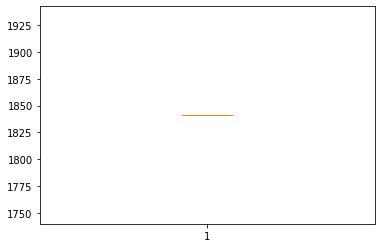

In [3]:
# persistence forecast for monthly car sales dataset
from math import sqrt
from numpy import median
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
       return data[:-n_test], data[-n_test:]
# root mean squared error or rmse
def measure_rmse(actual, predicted):
        return sqrt(mean_squared_error(actual, predicted))
# difference dataset
def difference(data, interval):
           return [data[i] - data[i - interval] for i in range(interval, len(data))]
# fit a model
def model_fit(train, config):
           return None
# forecast with a pre-fit model
def model_predict(model, history, config):

             values = list()
             for offset in config:
                 values.append(history[-offset])
             return median(values)
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
                    predictions = list()
# split dataset
                    train, test = train_test_split(data, n_test)
# fit model
                    model = model_fit(train, cfg)
# seed history with training dataset
                    history = [x for x in train]
# step over each time-step in the test set
                    for i in range(len(test)):
# fit model and make forecast for history
                        yhat = model_predict(model, history, cfg)
# store forecast in list of predictions
                        predictions.append(yhat)
# add actual observation to history for the next loop
                        history.append(test[i])
# estimate prediction error
                    error = measure_rmse(test, predictions)
                    print(' > %.3f' % error)
                    return error
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
# fit and evaluate the model n times
         scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
         return scores
# summarize model performance
def summarize_scores(name, scores):
# print a summary
         scores_m, score_std = mean(scores), std(scores)
         print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
# box and whisker plot
         pyplot.boxplot(scores)
         pyplot.show()
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# define config
config = [12, 24, 36]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('persistence', scores)

In [6]:
!pip install keras

In [8]:
!pip install tensorflow

  Created wheel for termcolor: filename=termcolor-1.1.0-cp37-none-any.whl size=4835 sha256=b44dd72f4e94cbbf34f1cfc78292cf33ca7b3f56be7898074fcc107609a04215
  Stored in directory: C:\Users\MeghanaAishwarya\AppData\Local\pip\Cache\wheels\7c\06\54\bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
  Created wheel for absl-py: filename=absl_py-0.9.0-cp37-none-any.whl size=121936 sha256=3892773bf97b350d1152211dfd0b83b369e643604f52551f52eb9f3af4b8223a
  Stored in directory: C:\Users\MeghanaAishwarya\AppData\Local\pip\Cache\wheels\8e\28\49\fad4e7f0b9a1227708cbbee4487ac8558a7334849cb81c813d
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7546 sha256=d6eb5c956ed7718129038dd0e258f656e314db9e36961c02a8765aa878a18145
  Stored in directory: C:\Users\MeghanaAishwarya\AppData\Local\pip\Cache\wheels\5c\2e\7e\a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built termcolor absl-py gast
  Found existing installation: scipy 1.3.1
    Uninstalling scipy-1.3.1:


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\programdata\\anaconda3\\lib\\site-packages\\scipy\\cluster\\hierarchy.py'
Consider using the `--user` option or check the permissions.



In [12]:
!pip install --user  tensorflow

  Using cached https://files.pythonhosted.org/packages/34/d5/ce8c17971067c0184c9045112b755be5461d5ce5253ef65a367e1298d7c5/tensorflow-2.1.0-cp37-cp37m-win_amd64.whl


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [15]:
import tensorflow

ModuleNotFoundError: No module named 'tensorflow'

# Multilayer Perceptron Model

In [13]:
# evaluate mlp for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
     return data[:-n_test], data[-n_test:]
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
          df = DataFrame(data)
          cols = list()
# input sequence (t-n, ... t-1)
          for i in range(n_in, 0, -1):
             cols.append(df.shift(i))
# forecast sequence (t, t+1, ... t+n)
          for i in range(0, n_out):
             cols.append(df.shift(-i))
# put it all together
          agg = concat(cols, axis=1)
# drop rows with NaN values
          agg.dropna(inplace=True)
          return agg.values
# root mean squared error or rmse
def measure_rmse(actual, predicted):
         return sqrt(mean_squared_error(actual, predicted))
# fit a model
def model_fit(train, config):
# unpack config
        n_input, n_nodes, n_epochs, n_batch = config
# prepare data
        data = series_to_supervised(train, n_input)
        train_x, train_y = data[:, :-1], data[:, -1]
# define model
        model = Sequential()
        model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer='adam')
# fit
        model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
        return model
# forecast with a pre-fit model
def model_predict(model, history, config):
# unpack config
                n_input, _, _, _ = config
# prepare data
                x_input = array(history[-n_input:]).reshape(1, n_input)
# forecast
                yhat = model.predict(x_input, verbose=0)
                return yhat[0]
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
                predictions = list()

# split dataset
                train, test = train_test_split(data, n_test)
# fit model
                model = model_fit(train, cfg)
# seed history with training dataset
                history = [x for x in train]
# step over each time-step in the test set
                for i in range(len(test)):
# fit model and make forecast for history
                   yhat = model_predict(model, history, cfg)
# store forecast in list of predictions
                   predictions.append(yhat)
# add actual observation to history for the next loop
                   history.append(test[i])
# estimate prediction error
                error = measure_rmse(test, predictions)
                print(' > %.3f' % error)
                return error
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
# fit and evaluate the model n times
          scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
          return scores
# summarize model performance
def summarize_scores(name, scores):
# print a summary
         scores_m, score_std = mean(scores), std(scores)
         print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
# box and whisker plot
         pyplot.boxplot(scores)
         pyplot.show()
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# define config
config = [24, 500, 100, 100]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('mlp', scores)

Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow'

# Convolutional Neural Network Model

In [ ]:
# evaluate cnn for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
      return data[:-n_test], data[-n_test:]
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
      df = DataFrame(data)
      cols = list()
# input sequence (t-n, ... t-1)
      for i in range(n_in, 0, -1):
          cols.append(df.shift(i))
# forecast sequence (t, t+1, ... t+n)
      for i in range(0, n_out):
          cols.append(df.shift(-i))
# put it all together
      agg = concat(cols, axis=1)
# drop rows with NaN values
      agg.dropna(inplace=True)
      return agg.values
# root mean squared error or rmse
def measure_rmse(actual, predicted):
           return sqrt(mean_squared_error(actual, predicted))
# fit a model
def model_fit(train, config):
# unpack config
            n_input, n_filters, n_kernel, n_epochs, n_batch = config
# prepare data
           data = series_to_supervised(train, n_input)
           train_x, train_y = data[:, :-1], data[:, -1]
           train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
# define model
           model = Sequential()
           model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu',
           input_shape=(n_input, 1)))
           model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu'))
           model.add(MaxPooling1D(pool_size=2))
           model.add(Flatten())
           model.add(Dense(1))
           model.compile(loss='mse', optimizer='adam')
# fit
           model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
           return model
# forecast with a pre-fit model
def model_predict(model, history, config):
# unpack config
        n_input, _, _, _, _ = config
# prepare data
        x_input = array(history[-n_input:]).reshape((1, n_input, 1))
# forecast
        yhat = model.predict(x_input, verbose=0)
        return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
        predictions = list()
# split dataset
        train, test = train_test_split(data, n_test)
# fit model
        model = model_fit(train, cfg)
# seed history with training dataset
        history = [x for x in train]
# step over each time-step in the test set
        for i in range(len(test)):
# fit model and make forecast for history
          yhat = model_predict(model, history, cfg)
# store forecast in list of predictions
          predictions.append(yhat)
# add actual observation to history for the next loop
          history.append(test[i])
# estimate prediction error
        error = measure_rmse(test, predictions)
        print(' > %.3f' % error)
        return error
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
# fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores
# summarize model performance
def summarize_scores(name, scores):
# print a summary
     scores_m, score_std = mean(scores), std(scores)
     print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
# box and whisker plot
pyplot.boxplot(scores)
pyplot.show()
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# define config
config = [36, 256, 3, 100, 100]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('cnn', scores)

# Recurrent Neural Network Models

In [ ]:
# evaluate lstm for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
      return data[:-n_test], data[-n_test:]
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
           df = DataFrame(data)
           cols = list()
# input sequence (t-n, ... t-1)
           for i in range(n_in, 0, -1):
              cols.append(df.shift(i))
# forecast sequence (t, t+1, ... t+n)
           for i in range(0, n_out):

               cols.append(df.shift(-i))
# put it all together
               agg = concat(cols, axis=1)
# drop rows with NaN values
               agg.dropna(inplace=True)
           return agg.values
# root mean squared error or rmse
def measure_rmse(actual, predicted):
           return sqrt(mean_squared_error(actual, predicted))
# difference dataset
def difference(data, interval):
          return [data[i] - data[i - interval] for i in range(interval, len(data))]
# fit a model
def model_fit(train, config):
# unpack config
        n_input, n_nodes, n_epochs, n_batch, n_diff = config
# prepare data
       if n_diff > 0:
            train = difference(train, n_diff)
            data = series_to_supervised(train, n_input)
            train_x, train_y = data[:, :-1], data[:, -1]
            train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
# define model
        model = Sequential()
        model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, 1)))
        model.add(Dense(n_nodes, activation='relu'))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer='adam')
# fit
        model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
        return model
# forecast with a pre-fit model
def model_predict(model, history, config):
# unpack config
            n_input, _, _, _, n_diff = config
# prepare data
            correction = 0.0
            if n_diff > 0:
               correction = history[-n_diff]
            history = difference(history, n_diff)
            x_input = array(history[-n_input:]).reshape((1, n_input, 1))
# forecast
            yhat = model.predict(x_input, verbose=0)
            return correction + yhat[0]
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
           predictions = list()
# split dataset
           train, test = train_test_split(data, n_test)
# fit model
           model = model_fit(train, cfg)

# seed history with training dataset
           history = [x for x in train]
# step over each time-step in the test set
           for i in range(len(test)):
# fit model and make forecast for history
              yhat = model_predict(model, history, cfg)
# store forecast in list of predictions
              predictions.append(yhat)
# add actual observation to history for the next loop
              history.append(test[i])
# estimate prediction error
error = measure_rmse(test, predictions)
print(' > %.3f' % error)
return error
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
# fit and evaluate the model n times
scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
return scores
# summarize model performance
def summarize_scores(name, scores):
# print a summary
scores_m, score_std = mean(scores), std(scores)
print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
# box and whisker plot
pyplot.boxplot(scores)
pyplot.show()
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# define config
config = [36, 50, 100, 100, 12]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('lstm', scores)

# CNN LSTM

In [ ]:
# evaluate cnn-lstm for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
return data[:-n_test], data[-n_test:]
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
df = DataFrame(data)
cols = list()
# input sequence (t-n, ... t-1)
for i in range(n_in, 0, -1):
cols.append(df.shift(i))
# forecast sequence (t, t+1, ... t+n)
for i in range(0, n_out):
cols.append(df.shift(-i))
# put it all together
agg = concat(cols, axis=1)
# drop rows with NaN values
14.6. Recurrent Neural Network Models 279
agg.dropna(inplace=True)
return agg.values
# root mean squared error or rmse
def measure_rmse(actual, predicted):
return sqrt(mean_squared_error(actual, predicted))
# fit a model
def model_fit(train, config):
# unpack config
n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
n_input = n_seq * n_steps
# prepare data
data = series_to_supervised(train, n_input)
train_x, train_y = data[:, :-1], data[:, -1]
train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, 1))
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel,
activation='relu', input_shape=(None,n_steps,1))))
model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel,
activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(n_nodes, activation='relu'))
model.add(Dense(n_nodes, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit
model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
return model
# forecast with a pre-fit model
def model_predict(model, history, config):
# unpack config
n_seq, n_steps, _, _, _, _, _ = config
n_input = n_seq * n_steps
# prepare data
x_input = array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))
# forecast
yhat = model.predict(x_input, verbose=0)
return yhat[0]
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
predictions = list()
# split dataset
train, test = train_test_split(data, n_test)
# fit model
model = model_fit(train, cfg)
# seed history with training dataset
history = [x for x in train]
# step over each time-step in the test set
for i in range(len(test)):
# fit model and make forecast for history
yhat = model_predict(model, history, cfg)
14.6. Recurrent Neural Network Models 280
# store forecast in list of predictions
predictions.append(yhat)
# add actual observation to history for the next loop
history.append(test[i])
# estimate prediction error
error = measure_rmse(test, predictions)
print(' > %.3f' % error)
return error
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
# fit and evaluate the model n times
scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
return scores
# summarize model performance
def summarize_scores(name, scores):
# print a summary
scores_m, score_std = mean(scores), std(scores)
print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
# box and whisker plot
pyplot.boxplot(scores)
pyplot.show()
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# define config
config = [3, 12, 64, 3, 100, 200, 100]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('cnn-lstm', scores)

# ConvLSTM

In [ ]:
# evaluate convlstm for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
14.6. Recurrent Neural Network Models 284
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from matplotlib import pyplot
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
return data[:-n_test], data[-n_test:]
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
df = DataFrame(data)
cols = list()
# input sequence (t-n, ... t-1)
for i in range(n_in, 0, -1):
cols.append(df.shift(i))
# forecast sequence (t, t+1, ... t+n)
for i in range(0, n_out):
cols.append(df.shift(-i))
# put it all together
agg = concat(cols, axis=1)
# drop rows with NaN values
agg.dropna(inplace=True)
return agg.values
# root mean squared error or rmse
def measure_rmse(actual, predicted):
return sqrt(mean_squared_error(actual, predicted))
# difference dataset
def difference(data, interval):
return [data[i] - data[i - interval] for i in range(interval, len(data))]
# fit a model
def model_fit(train, config):
# unpack config
n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
n_input = n_seq * n_steps
# prepare data
data = series_to_supervised(train, n_input)
train_x, train_y = data[:, :-1], data[:, -1]
train_x = train_x.reshape((train_x.shape[0], n_seq, 1, n_steps, 1))
# define model
model = Sequential()
model.add(ConvLSTM2D(filters=n_filters, kernel_size=(1,n_kernel), activation='relu',
input_shape=(n_seq, 1, n_steps, 1)))
model.add(Flatten())
model.add(Dense(n_nodes, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit
model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
14.6. Recurrent Neural Network Models 285
return model
# forecast with a pre-fit model
def model_predict(model, history, config):
# unpack config
n_seq, n_steps, _, _, _, _, _ = config
n_input = n_seq * n_steps
# prepare data
x_input = array(history[-n_input:]).reshape((1, n_seq, 1, n_steps, 1))
# forecast
yhat = model.predict(x_input, verbose=0)
return yhat[0]
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
predictions = list()
# split dataset
train, test = train_test_split(data, n_test)
# fit model
model = model_fit(train, cfg)
# seed history with training dataset
history = [x for x in train]
# step over each time-step in the test set
for i in range(len(test)):
# fit model and make forecast for history
yhat = model_predict(model, history, cfg)
# store forecast in list of predictions
predictions.append(yhat)
# add actual observation to history for the next loop
history.append(test[i])
# estimate prediction error
error = measure_rmse(test, predictions)
print(' > %.3f' % error)
return error
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
# fit and evaluate the model n times
scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
return scores
# summarize model performance
def summarize_scores(name, scores):
# print a summary
scores_m, score_std = mean(scores), std(scores)
print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
# box and whisker plot
pyplot.boxplot(scores)
pyplot.show()
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# define config
config = [3, 12, 256, 3, 200, 200, 100]
14.6. Recurrent Neural Network Models 286
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('convlstm', scores)

# How to Grid Search Deep Learning Models for Univariate Forecasting

In [ ]:
# grid search persistence models for monthly airline passengers dataset
from math import sqrt
from numpy import mean
from pandas import read_csv
from sklearn.metrics import mean_squared_error
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
return data[:-n_test], data[-n_test:]
15.3. Develop a Grid Search Framework 298
# root mean squared error or rmse
def measure_rmse(actual, predicted):
return sqrt(mean_squared_error(actual, predicted))
# fit a model
def model_fit(train, config):
return None
# forecast with a pre-fit model
def model_predict(model, history, offset):
return history[-offset]
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
predictions = list()
# split dataset
train, test = train_test_split(data, n_test)
# fit model
model = model_fit(train, cfg)
# seed history with training dataset
history = [x for x in train]
# step over each time-step in the test set
for i in range(len(test)):
# fit model and make forecast for history
yhat = model_predict(model, history, cfg)
# store forecast in list of predictions
predictions.append(yhat)
# add actual observation to history for the next loop
history.append(test[i])
# estimate prediction error
error = measure_rmse(test, predictions)
print(' > %.3f' % error)
return error
# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
# convert config to a key
key = str(config)
# fit and evaluate the model n times
scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
# summarize score
result = mean(scores)
print('> Model[%s] %.3f' % (key, result))
return (key, result)
# grid search configs
def grid_search(data, cfg_list, n_test):
# evaluate configs
scores = scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
# sort configs by error, asc
scores.sort(key=lambda tup: tup[1])
return scores
# define dataset
series = read_csv('monthly-airline-passengers.csv', header=0, index_col=0)
data = series.values
15.4. Multilayer Perceptron Model 299
# data split
n_test = 12
# model configs
cfg_list = [1, 6, 12, 24, 36]
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 10 configs
for cfg, error in scores[:10]:
print(cfg, error)

 # Multilayer Perceptron Model

In [ ]:
# grid search mlps for monthly airline passengers dataset
from math import sqrt
from numpy import array
from numpy import mean
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
return data[:-n_test], data[-n_test:]
15.4. Multilayer Perceptron Model 303
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
df = DataFrame(data)
cols = list()
# input sequence (t-n, ... t-1)
for i in range(n_in, 0, -1):
cols.append(df.shift(i))
# forecast sequence (t, t+1, ... t+n)
for i in range(0, n_out):
cols.append(df.shift(-i))
# put it all together
agg = concat(cols, axis=1)
# drop rows with NaN values
agg.dropna(inplace=True)
return agg.values
# root mean squared error or rmse
def measure_rmse(actual, predicted):
return sqrt(mean_squared_error(actual, predicted))
# difference dataset
def difference(data, order):
return [data[i] - data[i - order] for i in range(order, len(data))]
# fit a model
def model_fit(train, config):
# unpack config
n_input, n_nodes, n_epochs, n_batch, n_diff = config
# prepare data
if n_diff > 0:
train = difference(train, n_diff)
# transform series into supervised format
data = series_to_supervised(train, n_in=n_input)
# separate inputs and outputs
train_x, train_y = data[:, :-1], data[:, -1]
# define model
model = Sequential()
model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit model
model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
return model
# forecast with the fit model
def model_predict(model, history, config):
# unpack config
n_input, _, _, _, n_diff = config
# prepare data
correction = 0.0
if n_diff > 0:
correction = history[-n_diff]
history = difference(history, n_diff)
# shape input for model
x_input = array(history[-n_input:]).reshape((1, n_input))
15.4. Multilayer Perceptron Model 304
# make forecast
yhat = model.predict(x_input, verbose=0)
# correct forecast if it was differenced
return correction + yhat[0]
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
predictions = list()
# split dataset
train, test = train_test_split(data, n_test)
# fit model
model = model_fit(train, cfg)
# seed history with training dataset
history = [x for x in train]
# step over each time-step in the test set
for i in range(len(test)):
# fit model and make forecast for history
yhat = model_predict(model, history, cfg)
# store forecast in list of predictions
predictions.append(yhat)
# add actual observation to history for the next loop
history.append(test[i])
# estimate prediction error
error = measure_rmse(test, predictions)
print(' > %.3f' % error)
return error
# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
# convert config to a key
key = str(config)
# fit and evaluate the model n times
scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
# summarize score
result = mean(scores)
print('> Model[%s] %.3f' % (key, result))
return (key, result)
# grid search configs
def grid_search(data, cfg_list, n_test):
# evaluate configs
scores = scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
# sort configs by error, asc
scores.sort(key=lambda tup: tup[1])
return scores
# create a list of configs to try
def model_configs():
# define scope of configs
n_input = [12]
n_nodes = [50, 100]
n_epochs = [100]
n_batch = [1, 150]
n_diff = [0, 12]
# create configs
configs = list()
15.4. Multilayer Perceptron Model 305
for i in n_input:
for j in n_nodes:
for k in n_epochs:
for l in n_batch:
for m in n_diff:
cfg = [i, j, k, l, m]
configs.append(cfg)
print('Total configs: %d' % len(configs))
return configs
# define dataset
series = read_csv('monthly-airline-passengers.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# model configs
cfg_list = model_configs()
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
print(cfg, error)

# Convolutional Neural Network Model

In [ ]:
# grid search cnn for monthly airline passengers dataset
from math import sqrt
from numpy import array
from numpy import mean
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
15.5. Convolutional Neural Network Model 309
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
return data[:-n_test], data[-n_test:]
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
df = DataFrame(data)
cols = list()
# input sequence (t-n, ... t-1)
for i in range(n_in, 0, -1):
cols.append(df.shift(i))
# forecast sequence (t, t+1, ... t+n)
for i in range(0, n_out):
cols.append(df.shift(-i))
# put it all together
agg = concat(cols, axis=1)
# drop rows with NaN values
agg.dropna(inplace=True)
return agg.values
# root mean squared error or rmse
def measure_rmse(actual, predicted):
return sqrt(mean_squared_error(actual, predicted))
# difference dataset
def difference(data, order):
return [data[i] - data[i - order] for i in range(order, len(data))]
# fit a model
def model_fit(train, config):
# unpack config
n_input, n_filters, n_kernel, n_epochs, n_batch, n_diff = config
# prepare data
if n_diff > 0:
train = difference(train, n_diff)
# transform series into supervised format
data = series_to_supervised(train, n_in=n_input)
# separate inputs and outputs
train_x, train_y = data[:, :-1], data[:, -1]
# reshape input data into [samples, timesteps, features]
n_features = 1
train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
# define model
model = Sequential()
model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu',
input_shape=(n_input, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit
model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
return model
15.5. Convolutional Neural Network Model 310
# forecast with the fit model
def model_predict(model, history, config):
# unpack config
n_input, _, _, _, _, n_diff = config
# prepare data
correction = 0.0
if n_diff > 0:
correction = history[-n_diff]
history = difference(history, n_diff)
x_input = array(history[-n_input:]).reshape((1, n_input, 1))
# forecast
yhat = model.predict(x_input, verbose=0)
return correction + yhat[0]
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
predictions = list()
# split dataset
train, test = train_test_split(data, n_test)
# fit model
model = model_fit(train, cfg)
# seed history with training dataset
history = [x for x in train]
# step over each time-step in the test set
for i in range(len(test)):
# fit model and make forecast for history
yhat = model_predict(model, history, cfg)
# store forecast in list of predictions
predictions.append(yhat)
# add actual observation to history for the next loop
history.append(test[i])
# estimate prediction error
error = measure_rmse(test, predictions)
print(' > %.3f' % error)
return error
# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
# convert config to a key
key = str(config)
# fit and evaluate the model n times
scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
# summarize score
result = mean(scores)
print('> Model[%s] %.3f' % (key, result))
return (key, result)
# grid search configs
def grid_search(data, cfg_list, n_test):
# evaluate configs
scores = scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
# sort configs by error, asc
scores.sort(key=lambda tup: tup[1])
return scores
15.5. Convolutional Neural Network Model 311
# create a list of configs to try
def model_configs():
# define scope of configs
n_input = [12]
n_filters = [64]
n_kernels = [3, 5]
n_epochs = [100]
n_batch = [1, 150]
n_diff = [0, 12]
# create configs
configs = list()
for a in n_input:
for b in n_filters:
for c in n_kernels:
for d in n_epochs:
for e in n_batch:
for f in n_diff:
cfg = [a,b,c,d,e,f]
configs.append(cfg)
print('Total configs: %d' % len(configs))
return configs
# define dataset
series = read_csv('monthly-airline-passengers.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# model configs
cfg_list = model_configs()
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 10 configs
for cfg, error in scores[:3]:
print(cfg, error)

# Long Short-Term Memory Network Model

In [ ]:
# grid search lstm for monthly airline passengers dataset
from math import sqrt
from numpy import array
from numpy import mean
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
return data[:-n_test], data[-n_test:]
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
df = DataFrame(data)
15.6. Long Short-Term Memory Network Model 315
cols = list()
# input sequence (t-n, ... t-1)
for i in range(n_in, 0, -1):
cols.append(df.shift(i))
# forecast sequence (t, t+1, ... t+n)
for i in range(0, n_out):
cols.append(df.shift(-i))
# put it all together
agg = concat(cols, axis=1)
# drop rows with NaN values
agg.dropna(inplace=True)
return agg.values
# root mean squared error or rmse
def measure_rmse(actual, predicted):
return sqrt(mean_squared_error(actual, predicted))
# difference dataset
def difference(data, order):
return [data[i] - data[i - order] for i in range(order, len(data))]
# fit a model
def model_fit(train, config):
# unpack config
n_input, n_nodes, n_epochs, n_batch, n_diff = config
# prepare data
if n_diff > 0:
train = difference(train, n_diff)
# transform series into supervised format
data = series_to_supervised(train, n_in=n_input)
# separate inputs and outputs
train_x, train_y = data[:, :-1], data[:, -1]
# reshape input data into [samples, timesteps, features]
n_features = 1
train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(n_nodes, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit model
model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
return model
# forecast with the fit model
def model_predict(model, history, config):
# unpack config
n_input, _, _, _, n_diff = config
# prepare data
correction = 0.0
if n_diff > 0:
correction = history[-n_diff]
history = difference(history, n_diff)
# reshape sample into [samples, timesteps, features]
x_input = array(history[-n_input:]).reshape((1, n_input, 1))
15.6. Long Short-Term Memory Network Model 316
# forecast
yhat = model.predict(x_input, verbose=0)
return correction + yhat[0]
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
predictions = list()
# split dataset
train, test = train_test_split(data, n_test)
# fit model
model = model_fit(train, cfg)
# seed history with training dataset
history = [x for x in train]
# step over each time-step in the test set
for i in range(len(test)):
# fit model and make forecast for history
yhat = model_predict(model, history, cfg)
# store forecast in list of predictions
predictions.append(yhat)
# add actual observation to history for the next loop
history.append(test[i])
# estimate prediction error
error = measure_rmse(test, predictions)
print(' > %.3f' % error)
return error
# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
# convert config to a key
key = str(config)
# fit and evaluate the model n times
scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
# summarize score
result = mean(scores)
print('> Model[%s] %.3f' % (key, result))
return (key, result)
# grid search configs
def grid_search(data, cfg_list, n_test):
# evaluate configs
scores = scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
# sort configs by error, asc
scores.sort(key=lambda tup: tup[1])
return scores
# create a list of configs to try
def model_configs():
# define scope of configs
n_input = [12]
n_nodes = [100]
n_epochs = [50]
n_batch = [1, 150]
n_diff = [12]
# create configs
configs = list()
for i in n_input:
15.6. Long Short-Term Memory Network Model 317
for j in n_nodes:
for k in n_epochs:
for l in n_batch:
for m in n_diff:
cfg = [i, j, k, l, m]
configs.append(cfg)
print('Total configs: %d' % len(configs))
return configs
# define dataset
series = read_csv('monthly-airline-passengers.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# model configs
cfg_list = model_configs()
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 10 configs
for cfg, error in scores[:3]:
print(cfg, error)

# How to Load and Explore Household Energy Usage Data

In [12]:
# load and clean-up power usage data
from numpy import nan
from pandas import read_csv
# load all data
dataset = read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False,
infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
# summarize
print(dataset.shape)

print(dataset.head())
# mark all missing values
dataset.replace('?', nan, inplace=True)
# add a column for for the remainder of sub metering
values = dataset.values.astype('float32')
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] +
values[:,6])
# save updated dataset
dataset.to_csv('household_power_consumption.csv')
# load the new dataset and summarize
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True,
parse_dates=['datetime'], index_col=['datetime'])
print(dataset.head())

(2075259, 7)
                    Global_active_power Global_reactive_power  Voltage  \
datetime                                                                 
2006-12-16 17:24:00               4.216                 0.418  234.840   
2006-12-16 17:25:00               5.360                 0.436  233.630   
2006-12-16 17:26:00               5.374                 0.498  233.290   
2006-12-16 17:27:00               5.388                 0.502  233.740   
2006-12-16 17:28:00               3.666                 0.528  235.680   

                    Global_intensity Sub_metering_1 Sub_metering_2  \
datetime                                                             
2006-12-16 17:24:00           18.400          0.000          1.000   
2006-12-16 17:25:00           23.000          0.000          1.000   
2006-12-16 17:26:00           23.000          0.000          2.000   
2006-12-16 17:27:00           23.000          0.000          1.000   
2006-12-16 17:28:00           15.800          0.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


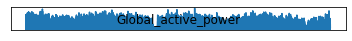

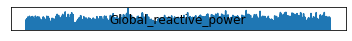

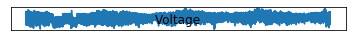

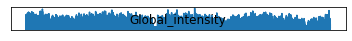

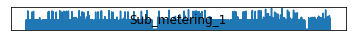

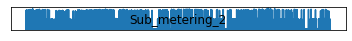

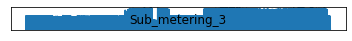

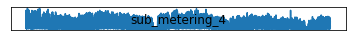

In [13]:
# line plots for power usage dataset
from pandas import read_csv
from matplotlib import pyplot
# load the new file
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True,
parse_dates=['datetime'], index_col=['datetime'])
# line plot for each variable
pyplot.figure()
for i in range(len(dataset.columns)):
# create subplot
     pyplot.subplot(len(dataset.columns), 1, i+1)
# get variable name
     name = dataset.columns[i]
# plot data
     pyplot.plot(dataset[name])
# set title
     pyplot.title(name, y=0)
# turn off ticks to remove clutter
     pyplot.yticks([])
     pyplot.xticks([])
     pyplot.show()

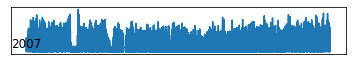

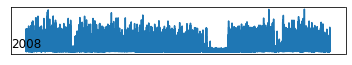

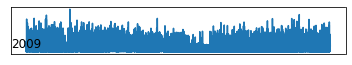

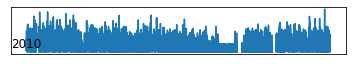

In [14]:
# yearly line plots for power usage dataset
from pandas import read_csv
from matplotlib import pyplot
# load the new file
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True,
parse_dates=['datetime'], index_col=['datetime'])
# plot active power for each year
years = ['2007', '2008', '2009', '2010']
pyplot.figure()
for i in range(len(years)):
# prepare subplot
     ax = pyplot.subplot(len(years), 1, i+1)
# determine the year to plot
     year = years[i]
# get all observations for the year
     result = dataset[str(year)]
# plot the active power for the year
     pyplot.plot(result['Global_active_power'])

# add a title to the subplot
     pyplot.title(str(year), y=0, loc='left')
# turn off ticks to remove clutter
     pyplot.yticks([])
     pyplot.xticks([])
     pyplot.show()

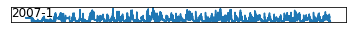

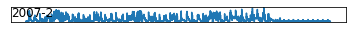

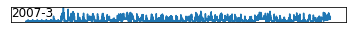

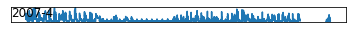

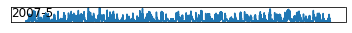

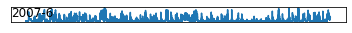

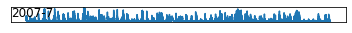

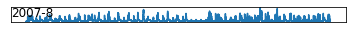

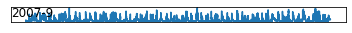

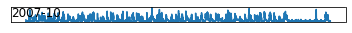

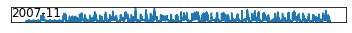

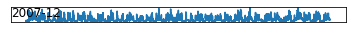

In [20]:
# monthly line plots for power usage dataset
#16.4. Patterns in Observations Over Time 330
from pandas import read_csv
from matplotlib import pyplot
# load the new file
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True,
parse_dates=['datetime'], index_col=['datetime'])
# plot active power for each year
months = [x for x in range(1, 13)]
pyplot.figure()
for i in range(len(months)):
# prepare subplot
     ax = pyplot.subplot(len(months), 1, i+1)
# determine the month to plot
     month = '2007-' + str(months[i])
# get all observations for the month
     result = dataset[month]
# plot the active power for the month
     pyplot.plot(result['Global_active_power'])
# add a title to the subplot
     pyplot.title(month, y=0, loc='left')
# turn off ticks to remove clutter
     pyplot.yticks([])
     pyplot.xticks([])
     pyplot.show()

# How to Develop Naive Models for Multi-step Energy Usage Forecasting

In [ ]:
# load and clean-up the power usage dataset
from numpy import nan
from numpy import isnan
from pandas import read_csv
# fill missing values with a value at the same time one day ago
def fill_missing(values):
one_day = 60 * 24
17.4. Model Evaluation 345
for row in range(values.shape[0]):
for col in range(values.shape[1]):
if isnan(values[row, col]):
values[row, col] = values[row - one_day, col]
# load all data
dataset = read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False,
infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
# mark all missing values
dataset.replace('?', nan, inplace=True)
# make dataset numeric
dataset = dataset.astype('float32')
# fill missing
fill_missing(dataset.values)
# add a column for for the remainder of sub metering
values = dataset.values
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] +
values[:,6])
# save updated dataset
dataset.to_csv('household_power_consumption.csv')

In [ ]:
# naive forecast strategies for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
# split a univariate dataset into train/test sets
def split_dataset(data):
# split into standard weeks
train, test = data[1:-328], data[-328:-6]
# restructure into windows of weekly data
train = array(split(train, len(train)/7))
test = array(split(test, len(test)/7))
return train, test
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
scores = list()
# calculate an RMSE score for each day
for i in range(actual.shape[1]):
# calculate mse
mse = mean_squared_error(actual[:, i], predicted[:, i])
# calculate rmse
rmse = sqrt(mse)
# store
scores.append(rmse)
# calculate overall RMSE
s = 0
for row in range(actual.shape[0]):
for col in range(actual.shape[1]):
s += (actual[row, col] - predicted[row, col])**2
score = sqrt(s / (actual.shape[0] * actual.shape[1]))
return score, scores
# summarize scores
def summarize_scores(name, score, scores):
s_scores = ', '.join(['%.1f' % s for s in scores])
print('%s: [%.3f] %s' % (name, score, s_scores))
# evaluate a single model
def evaluate_model(model_func, train, test):
# history is a list of weekly data
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
# predict the week
yhat_sequence = model_func(history)
# store the predictions
predictions.append(yhat_sequence)
# get real observation and add to history for predicting the next week
history.append(test[i, :])
predictions = array(predictions)
17.5. Develop Naive Forecast Models 353
# evaluate predictions days for each week
score, scores = evaluate_forecasts(test[:, :, 0], predictions)
return score, scores
# daily persistence model
def daily_persistence(history):
# get the data for the prior week
last_week = history[-1]
# get the total active power for the last day
value = last_week[-1, 0]
# prepare 7 day forecast
forecast = [value for _ in range(7)]
return forecast
# weekly persistence model
def weekly_persistence(history):
# get the data for the prior week
last_week = history[-1]
return last_week[:, 0]
# week one year ago persistence model
def week_one_year_ago_persistence(history):
# get the data for the prior week
last_week = history[-52]
return last_week[:, 0]
# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0,
infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# define the names and functions for the models we wish to evaluate
models = dict()
models['daily'] = daily_persistence
models['weekly'] = weekly_persistence
models['week-oya'] = week_one_year_ago_persistence
# evaluate each model
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
for name, func in models.items():
# evaluate and get scores
score, scores = evaluate_model(func, train, test)
# summarize scores
summarize_scores(name, score, scores)
# plot scores
pyplot.plot(days, scores, marker='o', label=name)
# show plot
pyplot.legend()
pyplot.show()

# How to Develop ARIMA Models for Multi-step Energy Usage Forecasting

In [ ]:
# acf and pacf plots of total power usage
from numpy import split
from numpy import array
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
# split a univariate dataset into train/test sets
def split_dataset(data):
# split into standard weeks
train, test = data[1:-328], data[-328:-6]
# restructure into windows of weekly data
train = array(split(train, len(train)/7))
test = array(split(test, len(test)/7))
return train, test
# convert windows of weekly multivariate data into a series of total power
def to_series(data):
# extract just the total power from each week
series = [week[:, 0] for week in data]
# flatten into a single series
series = array(series).flatten()
return series
# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0,
infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# convert training data into a series
series = to_series(train)
# plots
pyplot.figure()
18.5. Autocorrelation Analysis 360
lags = 365
# acf
axis = pyplot.subplot(2, 1, 1)
plot_acf(series, ax=axis, lags=lags)
# pacf
axis = pyplot.subplot(2, 1, 2)
plot_pacf(series, ax=axis, lags=lags)
# show plot
pyplot.show()

In [ ]:
# arima forecast for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
# split a univariate dataset into train/test sets
def split_dataset(data):
# split into standard weeks
train, test = data[1:-328], data[-328:-6]
# restructure into windows of weekly data
train = array(split(train, len(train)/7))
test = array(split(test, len(test)/7))
return train, test
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
scores = list()
# calculate an RMSE score for each day
for i in range(actual.shape[1]):
# calculate mse
mse = mean_squared_error(actual[:, i], predicted[:, i])
# calculate rmse
rmse = sqrt(mse)
# store
scores.append(rmse)
# calculate overall RMSE
s = 0
for row in range(actual.shape[0]):
for col in range(actual.shape[1]):
s += (actual[row, col] - predicted[row, col])**2
score = sqrt(s / (actual.shape[0] * actual.shape[1]))
return score, scores
# summarize scores
def summarize_scores(name, score, scores):
s_scores = ', '.join(['%.1f' % s for s in scores])
print('%s: [%.3f] %s' % (name, score, s_scores))
# evaluate a single model
def evaluate_model(model_func, train, test):
# history is a list of weekly data
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
# predict the week
yhat_sequence = model_func(history)
# store the predictions
predictions.append(yhat_sequence)
# get real observation and add to history for predicting the next week
history.append(test[i, :])
18.6. Develop an Autoregressive Model 364
predictions = array(predictions)
# evaluate predictions days for each week
score, scores = evaluate_forecasts(test[:, :, 0], predictions)
return score, scores
# convert windows of weekly multivariate data into a series of total power
def to_series(data):
# extract just the total power from each week
series = [week[:, 0] for week in data]
# flatten into a single series
series = array(series).flatten()
return series
# arima forecast
def arima_forecast(history):
# convert history into a univariate series
series = to_series(history)
# define the model
model = ARIMA(series, order=(7,0,0))
# fit the model
model_fit = model.fit(disp=False)
# make forecast
yhat = model_fit.predict(len(series), len(series)+6)
return yhat
# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0,
infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# define the names and functions for the models we wish to evaluate
models = dict()
models['arima'] = arima_forecast
# evaluate each model
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
for name, func in models.items():
# evaluate and get scores
score, scores = evaluate_model(func, train, test)
# summarize scores
summarize_scores(name, score, scores)
# plot scores
pyplot.plot(days, scores, marker='o', label=name)
# show plot
pyplot.legend()
pyplot.show()

# How to Develop CNNs for Multi-step Energy Usage Forecasting

In [ ]:
# univariate multi-step cnn for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
# split a univariate dataset into train/test sets
def split_dataset(data):
# split into standard weeks
19.6. Univariate CNN Model 375
train, test = data[1:-328], data[-328:-6]
# restructure into windows of weekly data
train = array(split(train, len(train)/7))
test = array(split(test, len(test)/7))
return train, test
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
scores = list()
# calculate an RMSE score for each day
for i in range(actual.shape[1]):
# calculate mse
mse = mean_squared_error(actual[:, i], predicted[:, i])
# calculate rmse
rmse = sqrt(mse)
# store
scores.append(rmse)
# calculate overall RMSE
s = 0
for row in range(actual.shape[0]):
for col in range(actual.shape[1]):
s += (actual[row, col] - predicted[row, col])**2
score = sqrt(s / (actual.shape[0] * actual.shape[1]))
return score, scores
# summarize scores
def summarize_scores(name, score, scores):
s_scores = ', '.join(['%.1f' % s for s in scores])
print('%s: [%.3f] %s' % (name, score, s_scores))
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
# flatten data
data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
X, y = list(), list()
in_start = 0
# step over the entire history one time step at a time
for _ in range(len(data)):
# define the end of the input sequence
in_end = in_start + n_input
out_end = in_end + n_out
# ensure we have enough data for this instance
if out_end < len(data):
x_input = data[in_start:in_end, 0]
x_input = x_input.reshape((len(x_input), 1))
X.append(x_input)
y.append(data[in_end:out_end, 0])
# move along one time step
in_start += 1
return array(X), array(y)
# train the model
def build_model(train, n_input):
# prepare data
train_x, train_y = to_supervised(train, n_input)
# define parameters
19.6. Univariate CNN Model 376
verbose, epochs, batch_size = 0, 20, 4
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
# define model
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=3, activation='relu',
input_shape=(n_timesteps,n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(n_outputs))
model.compile(loss='mse', optimizer='adam')
# fit network
model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
return model
# make a forecast
def forecast(model, history, n_input):
# flatten data
data = array(history)
data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
# retrieve last observations for input data
input_x = data[-n_input:, 0]
# reshape into [1, n_input, 1]
input_x = input_x.reshape((1, len(input_x), 1))
# forecast the next week
yhat = model.predict(input_x, verbose=0)
# we only want the vector forecast
yhat = yhat[0]
return yhat
# evaluate a single model
def evaluate_model(train, test, n_input):
# fit model
model = build_model(train, n_input)
# history is a list of weekly data
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
# predict the week
yhat_sequence = forecast(model, history, n_input)
# store the predictions
predictions.append(yhat_sequence)
# get real observation and add to history for predicting the next week
history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)
score, scores = evaluate_forecasts(test[:, :, 0], predictions)
return score, scores
# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0,
infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
19.6. Univariate CNN Model 377
n_input = 7
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.show()

# Multi-channel CNN Model

In [ ]:
# multichannel multi-step cnn for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
# split a univariate dataset into train/test sets
def split_dataset(data):
# split into standard weeks
train, test = data[1:-328], data[-328:-6]
# restructure into windows of weekly data
train = array(split(train, len(train)/7))
19.7. Multi-channel CNN Model 382
test = array(split(test, len(test)/7))
return train, test
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
scores = list()
# calculate an RMSE score for each day
for i in range(actual.shape[1]):
# calculate mse
mse = mean_squared_error(actual[:, i], predicted[:, i])
# calculate rmse
rmse = sqrt(mse)
# store
scores.append(rmse)
# calculate overall RMSE
s = 0
for row in range(actual.shape[0]):
for col in range(actual.shape[1]):
s += (actual[row, col] - predicted[row, col])**2
score = sqrt(s / (actual.shape[0] * actual.shape[1]))
return score, scores
# summarize scores
def summarize_scores(name, score, scores):
s_scores = ', '.join(['%.1f' % s for s in scores])
print('%s: [%.3f] %s' % (name, score, s_scores))
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
# flatten data
data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
X, y = list(), list()
in_start = 0
# step over the entire history one time step at a time
for _ in range(len(data)):
# define the end of the input sequence
in_end = in_start + n_input
out_end = in_end + n_out
# ensure we have enough data for this instance
if out_end < len(data):
X.append(data[in_start:in_end, :])
y.append(data[in_end:out_end, 0])
# move along one time step
in_start += 1
return array(X), array(y)
# train the model
def build_model(train, n_input):
# prepare data
train_x, train_y = to_supervised(train, n_input)
# define parameters
verbose, epochs, batch_size = 0, 70, 16
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
# define model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',
19.7. Multi-channel CNN Model 383
input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs))
model.compile(loss='mse', optimizer='adam')
# fit network
model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
return model
# make a forecast
def forecast(model, history, n_input):
# flatten data
data = array(history)
data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
# retrieve last observations for input data
input_x = data[-n_input:, :]
# reshape into [1, n_input, n]
input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
# forecast the next week
yhat = model.predict(input_x, verbose=0)
# we only want the vector forecast
yhat = yhat[0]
return yhat
# evaluate a single model
def evaluate_model(train, test, n_input):
# fit model
model = build_model(train, n_input)
# history is a list of weekly data
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
# predict the week
yhat_sequence = forecast(model, history, n_input)
# store the predictions
predictions.append(yhat_sequence)
# get real observation and add to history for predicting the next week
history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)
score, scores = evaluate_forecasts(test[:, :, 0], predictions)
return score, scores
# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0,
infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
19.7. Multi-channel CNN Model 384
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.show()

# Multi-headed CNN Model

In [ ]:
# multi headed multi-step cnn for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate
# split a univariate dataset into train/test sets
def split_dataset(data):
# split into standard weeks
train, test = data[1:-328], data[-328:-6]
# restructure into windows of weekly data
train = array(split(train, len(train)/7))
test = array(split(test, len(test)/7))
return train, test
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
scores = list()
# calculate an RMSE score for each day
for i in range(actual.shape[1]):
# calculate mse
mse = mean_squared_error(actual[:, i], predicted[:, i])
# calculate rmse
rmse = sqrt(mse)
# store
scores.append(rmse)
# calculate overall RMSE
s = 0
for row in range(actual.shape[0]):
for col in range(actual.shape[1]):
s += (actual[row, col] - predicted[row, col])**2
score = sqrt(s / (actual.shape[0] * actual.shape[1]))
return score, scores
19.8. Multi-headed CNN Model 389
# summarize scores
def summarize_scores(name, score, scores):
s_scores = ', '.join(['%.1f' % s for s in scores])
print('%s: [%.3f] %s' % (name, score, s_scores))
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
# flatten data
data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
X, y = list(), list()
in_start = 0
# step over the entire history one time step at a time
for _ in range(len(data)):
# define the end of the input sequence
in_end = in_start + n_input
out_end = in_end + n_out
# ensure we have enough data for this instance
if out_end < len(data):
X.append(data[in_start:in_end, :])
y.append(data[in_end:out_end, 0])
# move along one time step
in_start += 1
return array(X), array(y)
# plot training history
def plot_history(history):
# plot loss
pyplot.subplot(2, 1, 1)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.title('loss', y=0, loc='center')
pyplot.legend()
# plot rmse
pyplot.subplot(2, 1, 2)
pyplot.plot(history.history['rmse'], label='train')
pyplot.plot(history.history['val_rmse'], label='test')
pyplot.title('rmse', y=0, loc='center')
pyplot.legend()
pyplot.show()
# train the model
def build_model(train, n_input):
# prepare data
train_x, train_y = to_supervised(train, n_input)
# define parameters
verbose, epochs, batch_size = 0, 25, 16
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
# create a channel for each variable
in_layers, out_layers = list(), list()
for _ in range(n_features):
inputs = Input(shape=(n_timesteps,1))
conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
conv2 = Conv1D(filters=32, kernel_size=3, activation='relu')(conv1)
pool1 = MaxPooling1D(pool_size=2)(conv2)
flat = Flatten()(pool1)
# store layers
19.8. Multi-headed CNN Model 390
in_layers.append(inputs)
out_layers.append(flat)
# merge heads
merged = concatenate(out_layers)
# interpretation
dense1 = Dense(200, activation='relu')(merged)
dense2 = Dense(100, activation='relu')(dense1)
outputs = Dense(n_outputs)(dense2)
model = Model(inputs=in_layers, outputs=outputs)
# compile model
model.compile(loss='mse', optimizer='adam')
# plot the model
plot_model(model, show_shapes=True, to_file='multiheaded_cnn.png')
# fit network
input_data = [train_x[:,:,i].reshape((train_x.shape[0],n_timesteps,1)) for i in
range(n_features)]
model.fit(input_data, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
return model
# make a forecast
def forecast(model, history, n_input):
# flatten data
data = array(history)
data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
# retrieve last observations for input data
input_x = data[-n_input:, :]
# reshape into n input arrays
input_x = [input_x[:,i].reshape((1,input_x.shape[0],1)) for i in range(input_x.shape[1])]
# forecast the next week
yhat = model.predict(input_x, verbose=0)
# we only want the vector forecast
yhat = yhat[0]
return yhat
# evaluate a single model
def evaluate_model(train, test, n_input):
# fit model
model = build_model(train, n_input)
# history is a list of weekly data
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
# predict the week
yhat_sequence = forecast(model, history, n_input)
# store the predictions
predictions.append(yhat_sequence)
# get real observation and add to history for predicting the next week
history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)
score, scores = evaluate_forecasts(test[:, :, 0], predictions)
return score, scores
# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0,
19.8. Multi-headed CNN Model 391
infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.show()

# How to Develop LSTMs for Multi-step Energy Usage Forecasting

In [ ]:
# univariate multi-step lstm for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# split a univariate dataset into train/test sets
def split_dataset(data):
# split into standard weeks
train, test = data[1:-328], data[-328:-6]
# restructure into windows of weekly data
train = array(split(train, len(train)/7))
test = array(split(test, len(test)/7))
return train, test
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
scores = list()
# calculate an RMSE score for each day
for i in range(actual.shape[1]):
# calculate mse
mse = mean_squared_error(actual[:, i], predicted[:, i])
# calculate rmse
rmse = sqrt(mse)
# store
scores.append(rmse)
20.6. Univariate Input and Vector Output 401
# calculate overall RMSE
s = 0
for row in range(actual.shape[0]):
for col in range(actual.shape[1]):
s += (actual[row, col] - predicted[row, col])**2
score = sqrt(s / (actual.shape[0] * actual.shape[1]))
return score, scores
# summarize scores
def summarize_scores(name, score, scores):
s_scores = ', '.join(['%.1f' % s for s in scores])
print('%s: [%.3f] %s' % (name, score, s_scores))
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
# flatten data
data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
X, y = list(), list()
in_start = 0
# step over the entire history one time step at a time
for _ in range(len(data)):
# define the end of the input sequence
in_end = in_start + n_input
out_end = in_end + n_out
# ensure we have enough data for this instance
if out_end < len(data):
x_input = data[in_start:in_end, 0]
x_input = x_input.reshape((len(x_input), 1))
X.append(x_input)
y.append(data[in_end:out_end, 0])
# move along one time step
in_start += 1
return array(X), array(y)
# train the model
def build_model(train, n_input):
# prepare data
train_x, train_y = to_supervised(train, n_input)
# define parameters
verbose, epochs, batch_size = 0, 70, 16
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs))
model.compile(loss='mse', optimizer='adam')
# fit network
model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
return model
# make a forecast
def forecast(model, history, n_input):
# flatten data
data = array(history)
data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
20.6. Univariate Input and Vector Output 402
# retrieve last observations for input data
input_x = data[-n_input:, 0]
# reshape into [1, n_input, 1]
input_x = input_x.reshape((1, len(input_x), 1))
# forecast the next week
yhat = model.predict(input_x, verbose=0)
# we only want the vector forecast
yhat = yhat[0]
return yhat
# evaluate a single model
def evaluate_model(train, test, n_input):
# fit model
model = build_model(train, n_input)
# history is a list of weekly data
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
# predict the week
yhat_sequence = forecast(model, history, n_input)
# store the predictions
predictions.append(yhat_sequence)
# get real observation and add to history for predicting the next week
history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)
score, scores = evaluate_forecasts(test[:, :, 0], predictions)
return score, scores
# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0,
infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 7
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

# Encoder-Decoder LSTM With Univariate Input

In [ ]:
# univariate multi-step encoder-decoder lstm for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
# split a univariate dataset into train/test sets
def split_dataset(data):
# split into standard weeks
train, test = data[1:-328], data[-328:-6]
# restructure into windows of weekly data
20.7. Encoder-Decoder LSTM With Univariate Input 407
train = array(split(train, len(train)/7))
test = array(split(test, len(test)/7))
return train, test
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
scores = list()
# calculate an RMSE score for each day
for i in range(actual.shape[1]):
# calculate mse
mse = mean_squared_error(actual[:, i], predicted[:, i])
# calculate rmse
rmse = sqrt(mse)
# store
scores.append(rmse)
# calculate overall RMSE
s = 0
for row in range(actual.shape[0]):
for col in range(actual.shape[1]):
s += (actual[row, col] - predicted[row, col])**2
score = sqrt(s / (actual.shape[0] * actual.shape[1]))
return score, scores
# summarize scores
def summarize_scores(name, score, scores):
s_scores = ', '.join(['%.1f' % s for s in scores])
print('%s: [%.3f] %s' % (name, score, s_scores))
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
# flatten data
data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
X, y = list(), list()
in_start = 0
# step over the entire history one time step at a time
for _ in range(len(data)):
# define the end of the input sequence
in_end = in_start + n_input
out_end = in_end + n_out
# ensure we have enough data for this instance
if out_end < len(data):
x_input = data[in_start:in_end, 0]
x_input = x_input.reshape((len(x_input), 1))
X.append(x_input)
y.append(data[in_end:out_end, 0])
# move along one time step
in_start += 1
return array(X), array(y)
# train the model
def build_model(train, n_input):
# prepare data
train_x, train_y = to_supervised(train, n_input)
# define parameters
verbose, epochs, batch_size = 0, 20, 16
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
20.7. Encoder-Decoder LSTM With Univariate Input 408
# reshape output into [samples, timesteps, features]
train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(RepeatVector(n_outputs))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='adam')
# fit network
model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
return model
# make a forecast
def forecast(model, history, n_input):
# flatten data
data = array(history)
data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
# retrieve last observations for input data
input_x = data[-n_input:, 0]
# reshape into [1, n_input, 1]
input_x = input_x.reshape((1, len(input_x), 1))
# forecast the next week
yhat = model.predict(input_x, verbose=0)
# we only want the vector forecast
yhat = yhat[0]
return yhat
# evaluate a single model
def evaluate_model(train, test, n_input):
# fit model
model = build_model(train, n_input)
# history is a list of weekly data
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
# predict the week
yhat_sequence = forecast(model, history, n_input)
# store the predictions
predictions.append(yhat_sequence)
# get real observation and add to history for predicting the next week
history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)
score, scores = evaluate_forecasts(test[:, :, 0], predictions)
return score, scores
# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0,
infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
20.7. Encoder-Decoder LSTM With Univariate Input 409
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

# Encoder-Decoder LSTM With Multivariate Input

In [ ]:
# multivariate multi-step encoder-decoder lstm for the power usage dataset
from math import sqrt
from numpy import split
20.8. Encoder-Decoder LSTM With Multivariate Input 412
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
# split a univariate dataset into train/test sets
def split_dataset(data):
# split into standard weeks
train, test = data[1:-328], data[-328:-6]
# restructure into windows of weekly data
train = array(split(train, len(train)/7))
test = array(split(test, len(test)/7))
return train, test
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
scores = list()
# calculate an RMSE score for each day
for i in range(actual.shape[1]):
# calculate mse
mse = mean_squared_error(actual[:, i], predicted[:, i])
# calculate rmse
rmse = sqrt(mse)
# store
scores.append(rmse)
# calculate overall RMSE
s = 0
for row in range(actual.shape[0]):
for col in range(actual.shape[1]):
s += (actual[row, col] - predicted[row, col])**2
score = sqrt(s / (actual.shape[0] * actual.shape[1]))
return score, scores
# summarize scores
def summarize_scores(name, score, scores):
s_scores = ', '.join(['%.1f' % s for s in scores])
print('%s: [%.3f] %s' % (name, score, s_scores))
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
# flatten data
data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
X, y = list(), list()
in_start = 0
# step over the entire history one time step at a time
for _ in range(len(data)):
# define the end of the input sequence
in_end = in_start + n_input
out_end = in_end + n_out
# ensure we have enough data for this instance
if out_end < len(data):
20.8. Encoder-Decoder LSTM With Multivariate Input 413
X.append(data[in_start:in_end, :])
y.append(data[in_end:out_end, 0])
# move along one time step
in_start += 1
return array(X), array(y)
# train the model
def build_model(train, n_input):
# prepare data
train_x, train_y = to_supervised(train, n_input)
# define parameters
verbose, epochs, batch_size = 0, 50, 16
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
# reshape output into [samples, timesteps, features]
train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(RepeatVector(n_outputs))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='adam')
# fit network
model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
return model
# make a forecast
def forecast(model, history, n_input):
# flatten data
data = array(history)
data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
# retrieve last observations for input data
input_x = data[-n_input:, :]
# reshape into [1, n_input, n]
input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
# forecast the next week
yhat = model.predict(input_x, verbose=0)
# we only want the vector forecast
yhat = yhat[0]
return yhat
# evaluate a single model
def evaluate_model(train, test, n_input):
# fit model
model = build_model(train, n_input)
# history is a list of weekly data
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
# predict the week
yhat_sequence = forecast(model, history, n_input)
# store the predictions
predictions.append(yhat_sequence)
# get real observation and add to history for predicting the next week
20.8. Encoder-Decoder LSTM With Multivariate Input 414
history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)
score, scores = evaluate_forecasts(test[:, :, 0], predictions)
return score, scores
# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0,
infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

# CNN-LSTM Encoder-Decoder With Univariate In-put

In [ ]:
# univariate multi-step encoder-decoder cnn-lstm for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
20.9. CNN-LSTM Encoder-Decoder With Univariate Input 417
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
# split a univariate dataset into train/test sets
def split_dataset(data):
# split into standard weeks
train, test = data[1:-328], data[-328:-6]
# restructure into windows of weekly data
train = array(split(train, len(train)/7))
test = array(split(test, len(test)/7))
return train, test
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
scores = list()
# calculate an RMSE score for each day
for i in range(actual.shape[1]):
# calculate mse
mse = mean_squared_error(actual[:, i], predicted[:, i])
# calculate rmse
rmse = sqrt(mse)
# store
scores.append(rmse)
# calculate overall RMSE
s = 0
for row in range(actual.shape[0]):
for col in range(actual.shape[1]):
s += (actual[row, col] - predicted[row, col])**2
score = sqrt(s / (actual.shape[0] * actual.shape[1]))
return score, scores
# summarize scores
def summarize_scores(name, score, scores):
s_scores = ', '.join(['%.1f' % s for s in scores])
print('%s: [%.3f] %s' % (name, score, s_scores))
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
# flatten data
data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
X, y = list(), list()
in_start = 0
# step over the entire history one time step at a time
for _ in range(len(data)):
# define the end of the input sequence
in_end = in_start + n_input
out_end = in_end + n_out
# ensure we have enough data for this instance
20.9. CNN-LSTM Encoder-Decoder With Univariate Input 418
if out_end < len(data):
x_input = data[in_start:in_end, 0]
x_input = x_input.reshape((len(x_input), 1))
X.append(x_input)
y.append(data[in_end:out_end, 0])
# move along one time step
in_start += 1
return array(X), array(y)
# train the model
def build_model(train, n_input):
# prepare data
train_x, train_y = to_supervised(train, n_input)
# define parameters
verbose, epochs, batch_size = 0, 20, 16
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
# reshape output into [samples, timesteps, features]
train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(n_outputs))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='adam')
# fit network
model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
return model
# make a forecast
def forecast(model, history, n_input):
# flatten data
data = array(history)
data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
# retrieve last observations for input data
input_x = data[-n_input:, 0]
# reshape into [1, n_input, 1]
input_x = input_x.reshape((1, len(input_x), 1))
# forecast the next week
yhat = model.predict(input_x, verbose=0)
# we only want the vector forecast
yhat = yhat[0]
return yhat
# evaluate a single model
def evaluate_model(train, test, n_input):
# fit model
model = build_model(train, n_input)
# history is a list of weekly data
history = [x for x in train]
# walk-forward validation over each week
20.9. CNN-LSTM Encoder-Decoder With Univariate Input 419
predictions = list()
for i in range(len(test)):
# predict the week
yhat_sequence = forecast(model, history, n_input)
# store the predictions
predictions.append(yhat_sequence)
# get real observation and add to history for predicting the next week
history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)
score, scores = evaluate_forecasts(test[:, :, 0], predictions)
return score, scores
# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0,
infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

# ConvLSTM Encoder-Decoder With Univariate In-put

In [ ]:
# univariate multi-step encoder-decoder convlstm for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
20.10. ConvLSTM Encoder-Decoder With Univariate Input 423
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
# split a univariate dataset into train/test sets
def split_dataset(data):
# split into standard weeks
train, test = data[1:-328], data[-328:-6]
# restructure into windows of weekly data
train = array(split(train, len(train)/7))
test = array(split(test, len(test)/7))
return train, test
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
scores = list()
# calculate an RMSE score for each day
for i in range(actual.shape[1]):
# calculate mse
mse = mean_squared_error(actual[:, i], predicted[:, i])
# calculate rmse
rmse = sqrt(mse)
# store
scores.append(rmse)
# calculate overall RMSE
s = 0
for row in range(actual.shape[0]):
for col in range(actual.shape[1]):
s += (actual[row, col] - predicted[row, col])**2
score = sqrt(s / (actual.shape[0] * actual.shape[1]))
return score, scores
# summarize scores
def summarize_scores(name, score, scores):
s_scores = ', '.join(['%.1f' % s for s in scores])
print('%s: [%.3f] %s' % (name, score, s_scores))
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
# flatten data
data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
X, y = list(), list()
in_start = 0
# step over the entire history one time step at a time
for _ in range(len(data)):
# define the end of the input sequence
in_end = in_start + n_input
out_end = in_end + n_out
# ensure we have enough data for this instance
if out_end < len(data):
x_input = data[in_start:in_end, 0]
x_input = x_input.reshape((len(x_input), 1))
X.append(x_input)
y.append(data[in_end:out_end, 0])
# move along one time step
20.10. ConvLSTM Encoder-Decoder With Univariate Input 424
in_start += 1
return array(X), array(y)
# train the model
def build_model(train, n_steps, n_length, n_input):
# prepare data
train_x, train_y = to_supervised(train, n_input)
# define parameters
verbose, epochs, batch_size = 0, 20, 16
n_features, n_outputs = train_x.shape[2], train_y.shape[1]
# reshape into subsequences [samples, timesteps, rows, cols, channels]
train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
# reshape output into [samples, timesteps, features]
train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu',
input_shape=(n_steps, 1, n_length, n_features)))
model.add(Flatten())
model.add(RepeatVector(n_outputs))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='adam')
# fit network
model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
return model
# make a forecast
def forecast(model, history, n_steps, n_length, n_input):
# flatten data
data = array(history)
data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
# retrieve last observations for input data
input_x = data[-n_input:, 0]
# reshape into [samples, timesteps, rows, cols, channels]
input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
# forecast the next week
yhat = model.predict(input_x, verbose=0)
# we only want the vector forecast
yhat = yhat[0]
return yhat
# evaluate a single model
def evaluate_model(train, test, n_steps, n_length, n_input):
# fit model
model = build_model(train, n_steps, n_length, n_input)
# history is a list of weekly data
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
# predict the week
yhat_sequence = forecast(model, history, n_steps, n_length, n_input)
# store the predictions
predictions.append(yhat_sequence)
20.10. ConvLSTM Encoder-Decoder With Univariate Input 425
# get real observation and add to history for predicting the next week
history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)
score, scores = evaluate_forecasts(test[:, :, 0], predictions)
return score, scores
# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0,
infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# define the number of subsequences and the length of subsequences
n_steps, n_length = 2, 7
# define the total days to use as input
n_input = n_length * n_steps
score, scores = evaluate_model(train, test, n_steps, n_length, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()